In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp
from keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, Embedding, Dense, LayerNormalization, Dropout, Softmax, concatenate, Add
from keras import optimizers
import tensorflow as tf
from utils import *

pygame 2.5.2 (SDL 2.28.3, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
dataset = pp.load_dataset("../adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])

channel_range, note_range, velocity_range, time_range = pp.ranges_from_songs(ClassicSongs,True,True,True,True)

n_Channels = int(channel_range[1])+1
n_Notes = int(note_range[1])+1
n_Velocities = int(velocity_range[1])+1

print("\nNumber of channels   :",n_Channels,"\nNumber of notes      :",n_Notes,"\nNumber of velocities :",n_Velocities,"\nTime range           :",time_range[0],time_range[1])


Number of channels   : 13 
Number of notes      : 120 
Number of velocities : 128 
Time range           : 0.0 190.285


In [3]:
seq_length = 30
val_split = 0.1
test_split = 0.1

Train_X, Train_y, Val_X, Val_y, Test_X, Test_y = pp.prep_data_transformer(seq_length,ClassicSongs,n_Channels,n_Notes,n_Velocities,val_split,test_split)

In [4]:
class MusicEmbedding(tf.keras.layers.Layer):
    def __init__(self, n_Channels, n_Notes, n_Velocities, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        
        tot_dim = int(n_Channels/2) + n_Notes + int(n_Velocities/5)
        self.d_Channels = max(int((d_model-1)*int(n_Channels/2)/tot_dim),2)
        self.d_Velocities = max(int((d_model-1)*int(n_Velocities/5)/tot_dim),4)
        self.d_Notes = d_model - 1 - self.d_Channels - self.d_Velocities
            
        self.Channel_Embedding = Embedding(n_Channels, self.d_Channels)
        self.Notes_Embedding = Embedding(n_Notes, self.d_Notes)
        self.Velocities_Embedding = Embedding(n_Velocities, self.d_Velocities)
        self.seq = tf.keras.Sequential([
          Dense(dff, activation='relu'),
          Dense(d_model),
          Dropout(dropout_rate)
        ])

    def call(self, x):
        chan = self.Channel_Embedding(x[0])
        note = self.Notes_Embedding(x[1])
        velo = self.Velocities_Embedding(x[2])
        
        # Scale to values between 0 and 1 ? (/time_range[1])
        time = tf.expand_dims(x[3],-1)
        out = concatenate([chan,note,velo,time])
        return self.seq(out)

In [5]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, seq_length):
        super().__init__()
        self.d_model = d_model
        self.seq_length = seq_length
        self.pos_encoding = self.positional_encoding(seq_length, d_model)
        
    def positional_encoding(self, length, depth):
        depth = depth/2

        positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
        depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

        angle_rates = 1 / (10000**depths)         # (1, depth)
        angle_rads = positions * angle_rates      # (pos, depth)

        pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)],axis=-1) 

        return tf.cast(pos_encoding, dtype=tf.float32)[tf.newaxis, :, :]

    def call(self, x):
        # This factor sets the relative scale of the embedding and positonal_encoding.
        # x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        return x + self.pos_encoding

In [6]:
class SelfAttentionBlock(tf.keras.layers.Layer):
    # Dropout ??
    def __init__(self, num_heads, d_model, **kwargs):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads, d_model, **kwargs)
        self.layer_norm = LayerNormalization()
        self.add = Add()

    def call(self, x):
        attn_output = self.mha(query=x,value=x,key=x,use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layer_norm(x)
        return x

In [7]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          Dense(dff, activation='relu'),
          Dense(d_model),
          Dropout(dropout_rate)
        ])
        self.add = Add()
        self.layer_norm = LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,dropout_rate=0.1):
        super().__init__()
        self.self_attention_block = SelfAttentionBlock(num_heads,d_model)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention_block(x)
        x = self.ffn(x)
        return x

In [35]:
class Transformer(tf.keras.Model):
    def __init__(self, n_Channels, n_Notes, n_Velocities, max_time, seq_length, d_model, n_layers, n_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.embedding = MusicEmbedding(n_Channels, n_Notes, n_Velocities, d_model, dff, dropout_rate)
        self.pos_enc = PositionalEncoding(d_model, seq_length)
        self.layer_norm = LayerNormalization()
        self.dec_layers = [DecoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(n_layers)]
        self.out_chan = Dense(n_Channels, activation="softmax",name="Channels")
        self.out_note = Dense(n_Notes, activation="softmax",name="Notes")
        self.out_velo = Dense(n_Velocities, activation="softmax",name="Velocities")
        self.out_time = Dense(1, activation = lambda x: ((1 + tf.tanh(x)) * 0.5 * max_time),name="Times")
    
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.pos_enc(x)
        x = self.layer_norm(x)
        for dec_layer in self.dec_layers:
            x = dec_layer(x)
        chan = self.out_chan(x)
        note = self.out_note(x)
        velo = self.out_velo(x)
        time = self.out_time(x)
        return [chan, note, velo, time]
    
    def generate(self, input_vec, output_length, mode="Max", T=1, reset=False):
        temp_vec = self.predict(input_vec)
        temp_vec = sample_probas(temp_vec,mode,T,True)
        output_vec = [[np.argmax(temp_vec[0][0,0,:])],[np.argmax(temp_vec[1][0,0,:])],[np.argmax(temp_vec[2][0,0,:])],[temp_vec[3][0,0,0]]]
        for _ in range(output_length-1):
            for i in range(4):
                input_vec[i] = np.concatenate((input_vec[i][:,1:],np.reshape([output_vec[i][-1]],(1,1))),axis=1)
            temp_vec = self.predict(input_vec)
            temp_vec = sample_probas(temp_vec,mode,T,True)
            output_vec[0] += [np.argmax(temp_vec[0][0,0,:])]
            output_vec[1] += [np.argmax(temp_vec[1][0,0,:])]
            output_vec[2] += [np.argmax(temp_vec[2][0,0,:])]
            output_vec[3] += [temp_vec[3][0,0,0]]
        return output_vec

In [39]:
d_model = 32  # must be even
n_layers = 2
n_heads = 8
dff = 4*d_model

n_batch = 200
learning_rate = 0.01

optimizer= optimizers.Adam(learning_rate=learning_rate)

losses = {
    'output_1': 'categorical_crossentropy',    # Channels
    'output_2': 'categorical_crossentropy',    # Notes
    'output_3': 'categorical_crossentropy',          # Velocities
    'output_4': 'mean_squared_error'           # Times
}


loss_weights_start = {
    'output_1': 1.0,      # Channels
    'output_2': 1.0,      # Notes
    'output_3': 1.0,      # Velocities
    'output_4': 1.0       # Times
}

loss_weights_then  = {
    'output_1': 0.5,     # Channels
    'output_2': 5.0,     # Notes
    'output_3': 1.0,    # Velocities
    'output_4': 1e-4     # Times
}

metrics = {
    'output_1': 'accuracy',          # Channels
    'output_2': 'accuracy',          # Notes
    'output_3': rounded_accuracy,    # Velocities
    'output_4': tol_accuracy         # Times
}

ClassicTransformer = Transformer(n_Channels, n_Notes, n_Velocities, time_range[1], seq_length, d_model, n_layers, n_heads, dff)
build = ClassicTransformer([Train_X[0][0:2,:],Train_X[1][0:2,:],Train_X[2][0:2,:],Train_X[3][0:2,:]])
ClassicTransformer.summary()
ClassicTransformer.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights_start, metrics=metrics)

loss = []
channels_accuracy = []
notes_accuracy = []
velocities_accuracy = []
times_accuracy = []
channels_loss = []
notes_loss = []
velocities_loss = []
times_loss = []

val_loss = []
val_channels_accuracy = []
val_notes_accuracy = []
val_velocities_accuracy = []
val_times_accuracy = []
val_channels_loss = []
val_notes_loss = []
val_velocities_loss = []
val_times_loss = []

Model: "transformer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 music_embedding_3 (MusicEmb  multiple                 11898     
 edding)                                                         
                                                                 
 positional_encoding_3 (Posi  multiple                 0         
 tionalEncoding)                                                 
                                                                 
 layer_normalization_15 (Lay  multiple                 64        
 erNormalization)                                                
                                                                 
 decoder_layer_6 (DecoderLay  multiple                 42048     
 er)                                                             
                                                                 
 decoder_layer_7 (DecoderLay  multiple               

In [40]:
n_epochs_start = 0
n_epochs_then  = 15

if n_epochs_start > 0:
    history = ClassicTransformer.fit(Train_X,Train_y, epochs=n_epochs_start, batch_size=n_batch, validation_data=(Val_X,Val_y))

    loss += history.history['loss']
    channels_accuracy += history.history['output_1_accuracy']
    notes_accuracy += history.history['output_2_accuracy']
    velocities_accuracy += history.history['output_3_rounded_accuracy']
    times_accuracy += history.history['output_4_tol_accuracy']
    channels_loss += history.history['output_1_loss']
    notes_loss += history.history['output_2_loss']
    velocities_loss += history.history['output_3_loss']
    times_loss += history.history['output_4_loss']

    val_loss += history.history['val_loss']
    val_channels_accuracy += history.history['val_output_1_accuracy']
    val_notes_accuracy += history.history['val_output_2_accuracy']
    val_velocities_accuracy += history.history['val_output_3_rounded_accuracy']
    val_times_accuracy += history.history['val_output_4_tol_accuracy']
    val_channels_loss += history.history['val_output_1_loss']
    val_notes_loss += history.history['val_output_2_loss']
    val_velocities_loss += history.history['val_output_3_loss']
    val_times_loss += history.history['val_output_4_loss']

ClassicTransformer.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights_then, metrics=metrics)
history = ClassicTransformer.fit(Train_X,Train_y, epochs=n_epochs_then, batch_size=n_batch, validation_data=(Val_X,Val_y))

loss += history.history['loss']
channels_accuracy += history.history['output_1_accuracy']
notes_accuracy += history.history['output_2_accuracy']
velocities_accuracy += history.history['output_3_rounded_accuracy']
times_accuracy += history.history['output_4_tol_accuracy']
channels_loss += history.history['output_1_loss']
notes_loss += history.history['output_2_loss']
velocities_loss += history.history['output_3_loss']
times_loss += history.history['output_4_loss']

val_loss += history.history['val_loss']
val_channels_accuracy += history.history['val_output_1_accuracy']
val_notes_accuracy += history.history['val_output_2_accuracy']
val_velocities_accuracy += history.history['val_output_3_rounded_accuracy']
val_times_accuracy += history.history['val_output_4_tol_accuracy']
val_channels_loss += history.history['val_output_1_loss']
val_notes_loss += history.history['val_output_2_loss']
val_velocities_loss += history.history['val_output_3_loss']
val_times_loss += history.history['val_output_4_loss']

Epoch 1/15
284/284 [==============================] - 70s 237ms/step - loss: 22.7695 - output_1_loss: 0.8135 - output_2_loss: 3.9275 - output_3_loss: 2.7245 - output_4_loss: 7.8781 - output_1_accuracy: 0.6952 - output_2_accuracy: 0.0380 - output_3_rounded_accuracy: 0.9929 - output_4_tol_accuracy: 0.0039 - val_loss: 21.7324 - val_output_1_loss: 0.7825 - val_output_2_loss: 3.8000 - val_output_3_loss: 2.3409 - val_output_4_loss: 0.4620 - val_output_1_accuracy: 0.6959 - val_output_2_accuracy: 0.0482 - val_output_3_rounded_accuracy: 0.9941 - val_output_4_tol_accuracy: 0.0023
Epoch 2/15
284/284 [==============================] - 67s 236ms/step - loss: 21.2986 - output_1_loss: 0.7620 - output_2_loss: 3.7228 - output_3_loss: 2.3037 - output_4_loss: 1.6381 - output_1_accuracy: 0.6961 - output_2_accuracy: 0.0541 - output_3_rounded_accuracy: 0.9941 - output_4_tol_accuracy: 0.0344 - val_loss: 20.8193 - val_output_1_loss: 0.7681 - val_output_2_loss: 3.6355 - val_output_3_loss: 2.2576 - val_output_4

KeyboardInterrupt: 

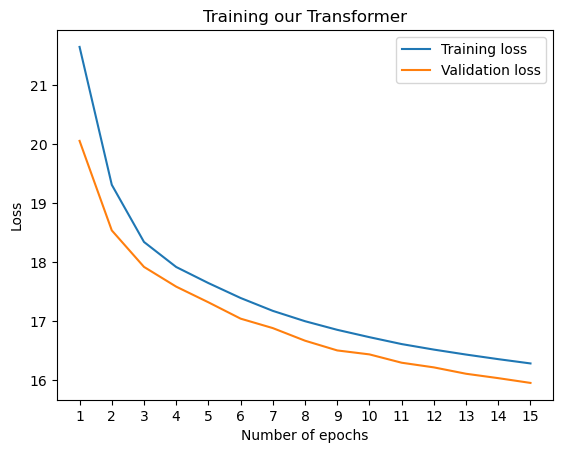

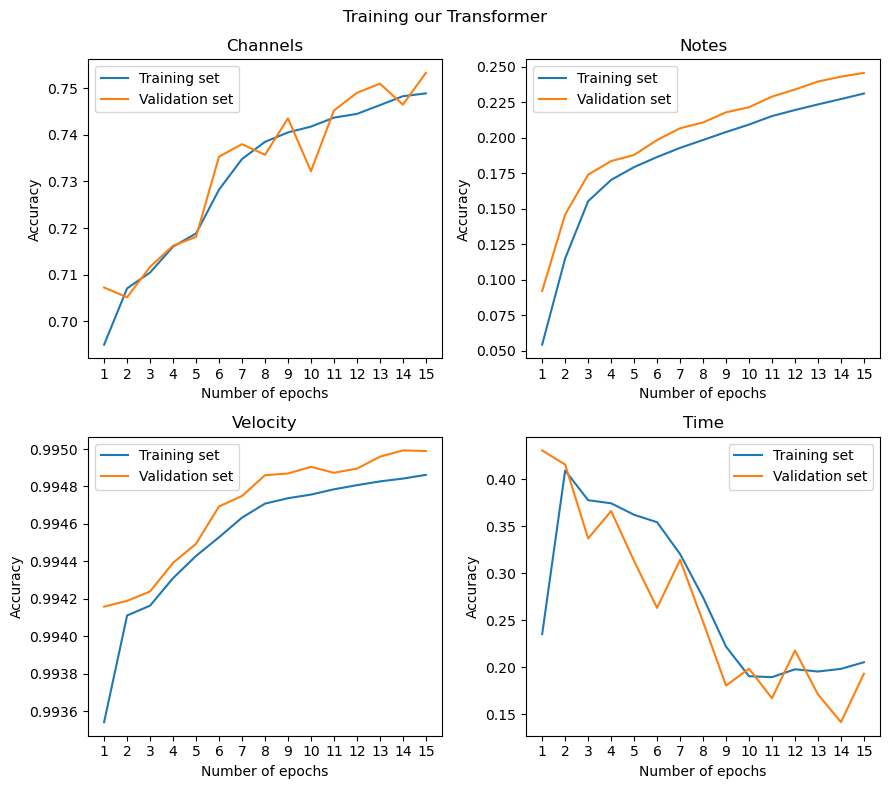

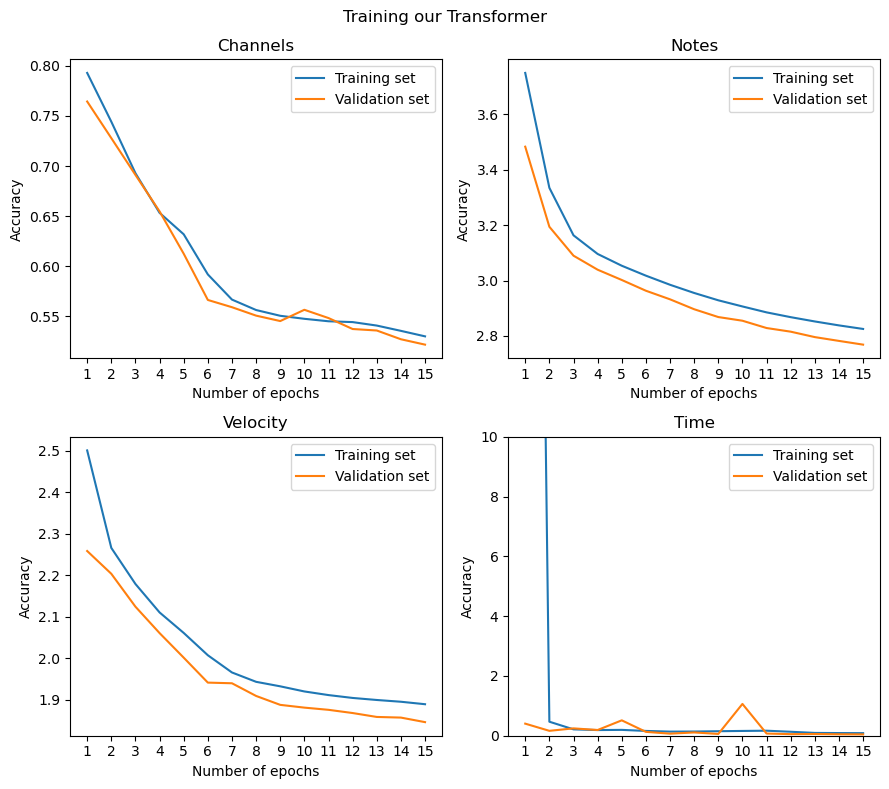

In [12]:
plot_training_results("Training our Transformer",loss,channels_accuracy,notes_accuracy,velocities_accuracy,times_accuracy,channels_loss,notes_loss,velocities_loss,times_loss,val_loss,val_channels_accuracy,val_notes_accuracy,val_velocities_accuracy,val_times_accuracy,val_channels_loss,val_notes_loss,val_velocities_loss,val_times_loss)

In [13]:
Out = ClassicTransformer.generate([Train_X[0][1:2,:],Train_X[1][1:2,:],Train_X[2][1:2,:],Train_X[3][1:2,:]],100,"SoftMax",1.0)
play_music(Out)

1/1 [==============================] - 0s 37ms/step


In [33]:
play_music(Out,tempo=150)

In [31]:
Out[3] = list(np.array(Out[3])*0.5)
Out[2]

[82,
 94,
 46,
 0,
 115,
 0,
 0,
 0,
 0,
 0,
 95,
 85,
 0,
 34,
 73,
 0,
 89,
 74,
 66,
 0,
 62,
 40,
 115,
 96,
 63,
 50,
 46,
 95,
 0,
 0,
 127,
 23,
 67,
 0,
 81,
 0,
 84,
 74,
 0,
 0,
 71,
 85,
 108,
 37,
 60,
 44,
 67,
 0,
 69,
 0,
 39,
 0,
 0,
 71,
 0,
 123,
 0,
 0,
 0,
 0,
 127,
 31,
 55,
 78,
 0,
 83,
 0,
 33,
 105,
 53,
 0,
 78,
 127,
 0,
 87,
 0,
 100,
 88,
 0,
 92,
 0,
 123,
 0,
 73,
 61,
 125,
 0,
 101,
 0,
 79,
 127,
 127,
 56,
 87,
 63,
 35,
 95,
 43,
 112,
 41]

In [32]:
Out[3]

[1.1411425,
 0.95472467,
 0.9171859,
 0.7189527,
 0.95663863,
 0.49808395,
 1.3089312,
 1.1146535,
 0.42994767,
 1.0399078,
 0.5675472,
 0.8620644,
 0.62608826,
 1.1755168,
 1.9138386,
 0.36890566,
 0.5860997,
 0.4338266,
 0.4164225,
 0.8620644,
 0.77073115,
 1.6994772,
 2.156373,
 0.7030033,
 0.8459618,
 0.36398047,
 0.9606195,
 0.46498552,
 0.5459069,
 0.5456518,
 0.7612636,
 0.60631084,
 0.9128732,
 1.8971235,
 0.4864727,
 0.36469504,
 1.1493087,
 1.0576437,
 0.6385927,
 0.8372853,
 1.9024317,
 0.58148074,
 0.39490977,
 0.6614834,
 0.8890638,
 1.7219342,
 1.2777722,
 0.70297766,
 1.0278116,
 1.0340129,
 1.6214906,
 1.4651345,
 1.2876738,
 0.9496464,
 0.62371504,
 1.3103094,
 1.247685,
 0.55978936,
 1.11325,
 0.8089334,
 0.4148403,
 0.41928065,
 1.1266476,
 0.87074095,
 0.6945307,
 1.2328331,
 4.081644,
 0.7186209,
 0.75021374,
 1.1571431,
 1.6429522,
 0.66589826,
 0.4178771,
 0.7413075,
 1.297065,
 0.2742039,
 0.48233858,
 1.2997954,
 0.5129106,
 1.2154543,
 0.80183905,
 1.5107372,
